In [1]:
## Bring in needed mods,
## set lables
## Define functions
import numpy as np, pandas as pd, scipy.stats as ss, seaborn as sns, os
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt, rc

xl280al = 'XL280'+r'$\alpha$'
xl280_label = 'XL280' +r'$\bf{a}$'
_431_label = '431'+r'$\mathrm{\alpha}$'

def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. Return F-statistic.

    Assumes site is coded as -1, 1
    """
    #pheno = pheno.dropna();assert len(pheno) > 0;
    coding = np.array(site,np.float)
    pheno = np.array(pheno,np.float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F

def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

def myminmax(x):
    x = np.array(x)
    return (x-x.min())/(x.max()-x.min())

In [2]:
%matplotlib inline

In [3]:
## Bring in genotype data
geno_path = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
geno_df = pd.read_csv(geno_path)

## Define chromosomes
chrlist = geno_df.Chrom.unique()
## Gather the length of each chromosome
clens = [geno_df[(geno_df.Chrom==chrom)]['Pos'].max() 
         for chrom in chrlist]
## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)
## calculate cumulative positions
cumpos = [0] + list(np.cumsum(clens))[:-1]

In [4]:
## Amphotericin B and thermal tolerance
## Set phenotype data path
file_path = '../DATA/PHENOTYPE/GROWTHCURVES/Tecan_qtlruns_Jan162019_curated_baselined_median51.csv.gz'
## Bring in phenotype data
df = pd.read_csv(file_path,index_col=0)
dfcol = df.columns.tolist()
time_ix = dfcol.index('6300s')
times_ixs = dfcol[time_ix:]
#df.index = df.strain
df = df[(df.strain.isin(geno_df.columns)) & (df.temp!=38)]
timex = [np.round(int(a[:-1])/(60**2),3) for a in times_ixs]
dx = np.max(np.diff(timex))
df.index = df.strain
df.drop('strain',inplace=True,axis=1)
df['AUC'] = df[times_ixs].sum(axis=1)*dx
df.head()

,date,row,column,plate,temp,amphB,length,Instrument,saturatedOD,premedia,...,250201s,251100s,252000s,252901s,253800s,254700s,255601s,256500s,257400s,AUC
strain,,,,,,,,,,,,,,,,,,,,,
SS-A837,Sep182017,e,7,2,30,0.0,72,Loaner,1.4500,YPD,...,1.4098,1.4098,1.4098,1.4098,1.4098,1.4098,1.4098,1.4098,1.4098,74.95100
SS-A837,Nov12017,e,7,2,30,0.0,72,Moon,1.4392,YPD,...,1.4162,1.4172,1.4172,1.4172,1.4172,1.4172,1.4172,1.4182,1.4182,70.85075
SS-A837,Nov82017,e,7,2,30,0.0,72,Moon,1.4800,YPD,...,1.4158,1.4168,1.4168,1.4168,1.4178,1.4178,1.4188,1.4188,1.4188,70.48700
SS-A837,Feb212018,e,7,2,30,0.0,72,Moon,1.6927,YPD,...,1.4262,1.4262,1.4272,1.4272,1.4272,1.4272,1.4272,1.4272,1.4272,74.84250
SS-B307,Sep182017,b,2,2,30,0.0,72,Loaner,1.5400,YPD,...,0.9590,0.9590,0.9590,0.9590,0.9610,0.9610,0.9620,0.9620,0.9620,43.06800


In [5]:
auc = df.groupby(['temp','amphB','strain']).agg(np.median
        ).copy().reset_index()[['temp','amphB','strain','AUC']]
auc.index = auc.strain
auc.drop('strain',inplace=True,axis=1)

aucs = pd.concat([a[1]['AUC'] for a in auc.groupby(['temp','amphB'])],axis=1)
aucs.columns = ['_'.join([str(k) for k in a[0]]) for a in auc.groupby(['temp','amphB'])]
print(aucs.shape[0])
aucs.head()

104


,30_0.0,30_0.075,30_0.125,30_0.175,37_0.0,37_0.075,37_0.125,37_0.175,39_0.0,39_0.075,39_0.125
strain,,,,,,,,,,,
SS-A837,72.846625,6.396750,1.581000,2.054625,60.49275,39.584125,8.383125,0.471125,17.089875,6.963200,0.012600
SS-B307,41.768125,23.671750,13.471400,8.164875,25.04775,14.971500,2.394925,0.034400,15.147750,6.904150,0.000000
SS-B310,42.613800,5.368000,0.677750,0.385800,11.57150,0.609500,0.653250,0.181125,0.001550,0.139625,0.035575
SS-B311,51.629500,47.838975,37.815875,26.589250,25.22050,21.242500,18.908500,6.748450,8.145000,6.247125,4.815250
SS-B312,34.049937,22.844500,5.067400,1.533375,16.75800,13.019000,5.445800,0.160375,8.318375,1.066300,0.355025


In [6]:
## Capsule
cap_path = '../DATA/PHENOTYPE/CAPSULE/Capsule_Phenotypes.csv'
capsule = pd.read_csv(cap_path)
capsule.drop('Sample.1',inplace=True,axis=1)
capsule.columns = ['strain'] + capsule.columns.tolist()[1:]
print(capsule.shape[0])
capsule.index = capsule.strain
capsule.drop('strain',inplace=True,axis=1)
capsule.head()

104


,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,Cell_Residual,QTL
strain,,,,,,,,,,,
SS-A837,7-120,2954.0,1093.0,1935.5,61.323907,37.304177,25.117309,15,2.144624,-1.179139,1.0
SS-B307,7-120,3015.0,831.0,2065.5,61.958189,32.512533,26.994920,15,3.635013,-6.198297,1.0
SS-B310,7-120,6371.0,2168.0,3964.5,90.064104,52.517844,34.967517,15,-5.550718,3.725538,0.0
SS-B311,7-150,3293.5,1023.5,2096.5,64.756295,36.099316,26.319158,15,1.251042,-3.615184,1.0
SS-B312,11-22,7008.5,1610.0,5398.5,94.452263,45.269625,47.179251,15,3.982097,-5.096695,0.0


In [7]:
## Melanization
melanin = pd.read_csv('../DATA/PHENOTYPE/MELANIN/Melanin_Phenotypes.csv',index_col=0)
print(melanin.shape[0])
melanin.head()

104


,Mean_intensity,QTL14
Strain,,
SS-B307,12310.311000,1
SS-B310,12255.142667,1
SS-B311,14045.272333,1
SS-B312,18635.336333,0
SS-B313,16597.829333,0


In [8]:
## Fludioxonil
fludio = pd.read_csv('../DATA/PHENOTYPE/FLUDIOXONIL/Cdx-predict-fludio-phenotype.csv')
fludio.columns = ['strain'] + fludio.columns.tolist()[1:]
to_drop = fludio[(fludio.strain=='SS-B575')].index[0]
fludio.drop(to_drop,axis=0,inplace=True)
fludio.index = fludio.strain
fludio.drop('strain',inplace=True,axis=1)
fludio['Outcome'] = fludio['Outcome'].apply(float)
print(fludio.shape[0])
fludio.head()

104


,SSK1,SSK2,Fludio,Row,Column,Plate,Outcome
strain,,,,,,,
SS-B357,1.0,1.0,Resistant,b,2,qtl1,1.0
SS-B360,0.0,0.0,Resistant,b,3,qtl1,1.0
SS-B364,0.0,1.0,Sensitive,b,4,qtl1,1.0
SS-B366,1.0,1.0,Resistant,b,5,qtl1,1.0
SS-B368,1.0,1.0,Resistant,b,6,qtl1,1.0


In [9]:
## Bring in Hydrogenperoxide phenotypes
H2o2 = pd.read_csv('../DATA/PHENOTYPE/H2O2/H2O2_data.csv',
                   index_col=0)
H2o2

,H2O2,SSK1,SSK2,RIC8
SS-A837,2.00,1.0,1.0,1.0
SS-B307,0.75,0.0,0.0,1.0
SS-B310,0.00,1.0,0.0,1.0
SS-B311,4.00,0.0,1.0,1.0
SS-B312,5.00,0.0,1.0,0.0
...,...,...,...,...
SS-C272,3.75,1.0,0.0,1.0
SS-C290,4.00,1.0,1.0,1.0
SS-C291,3.75,1.0,1.0,0.0
XL280a,4.50,0.0,0.0,0.0


## Hydrogenperoxide
H2o2 = pd.read_csv('/home/croth/H2O2_phenotypes.csv')
H2o2.columns = ['strain'] + H2o2.columns.tolist()[1:]
H2o2.index = H2o2.strain
H2o2.drop('strain',axis=1,inplace=True)
H2o2.head()

In [10]:
segs = [s for s in sorted(H2o2.index.tolist()) if s in geno_df.columns]
len(segs)

104

In [11]:
segs[:5]

['SS-A837', 'SS-B307', 'SS-B310', 'SS-B311', 'SS-B312']

In [12]:
capsule.T[segs].T['Residual'].values.shape

(104,)

In [13]:
pheno = pd.DataFrame(index=segs)
#pheno['Melanin'] = melanin.T[segs].T['Melanin'].values
pheno['Melanin'] = melanin.T[segs].T['Mean_intensity'].values

#pheno['Annulus'] = np.array(capsule.T[segs].T['Residual'].values,dtype=float)
pheno['Fludioxonil'] = fludio.T[segs].T['Outcome'].apply(float)
#pheno['H2O2'] = H2o2.T[segs].T['Score']
pheno['H2O2'] = H2o2.T[segs].T['H2O2']


for k in aucs.columns:
    pheno[k] = aucs[k].T[pheno.index]

pheno.shape

(104, 14)

from sklearn import preprocessing

minmax = preprocessing.MinMaxScaler()

def myminmax(x):
    return minmax.fit_transform(x.values.reshape(-1, 1)).T[0]

In [14]:
loci = geno_df.Block.drop_duplicates().index.tolist()
geno = geno_df.T[loci].T[pheno.index]
for s in geno.columns:
    geno[s] = np.array(geno[s],dtype=float)
geno.head()

,SS-A837,SS-B307,SS-B310,SS-B311,SS-B312,SS-B313,SS-B314,SS-B315,SS-B316,SS-B317,...,SS-C033,SS-C036,SS-C039,SS-C242,SS-C271,SS-C272,SS-C290,SS-C291,XL280a,XL280alpha
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
232,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
249,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
252,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
254,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
melanin_qtl = pd.DataFrame(geno[pheno.index].apply(
                association_logPval,axis=1,
                args=[pheno['Melanin'].values]))
melanin_qtl.columns = ['Melanin']
melanin_qtl[['Pos','Chrom']] = geno_df[['Pos','Chrom']].T[loci].T
melanin_qtl.head()

,Melanin,Pos,Chrom
0,0.540467,5016,Chr01
232,0.329530,35512,Chr01
249,0.343673,36364,Chr01
252,0.405084,36573,Chr01
254,0.469529,36769,Chr01


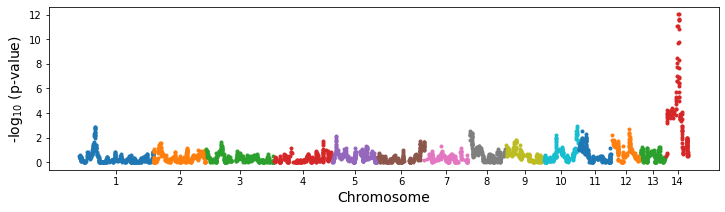

In [16]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i,c in enumerate(chrlist):
    tp = melanin_qtl[(melanin_qtl.Chrom==c)]
    plt.plot(tp.Pos.values+cumpos[i],tp.Melanin.values,'.')
plt.xticks(chrom_midpts,np.arange(1,15));
plt.xlabel('Chromosome',fontsize=14)
plt.ylabel('-log$_{10}$ (p-value)',fontsize=14);

In [17]:
pheno['QTL14'] = geno.T[melanin_qtl.Melanin.idxmax()][pheno.index]

In [18]:
pheno.head()

,Melanin,Fludioxonil,H2O2,30_0.0,30_0.075,30_0.125,30_0.175,37_0.0,37_0.075,37_0.125,37_0.175,39_0.0,39_0.075,39_0.125,QTL14
SS-A837,11169.802000,1.0,2.00,72.846625,6.396750,1.581000,2.054625,60.49275,39.584125,8.383125,0.471125,17.089875,6.963200,0.012600,1.0
SS-B307,12310.311000,1.0,0.75,41.768125,23.671750,13.471400,8.164875,25.04775,14.971500,2.394925,0.034400,15.147750,6.904150,0.000000,1.0
SS-B310,12255.142667,1.0,0.00,42.613800,5.368000,0.677750,0.385800,11.57150,0.609500,0.653250,0.181125,0.001550,0.139625,0.035575,1.0
SS-B311,14045.272333,0.0,4.00,51.629500,47.838975,37.815875,26.589250,25.22050,21.242500,18.908500,6.748450,8.145000,6.247125,4.815250,1.0
SS-B312,18635.336333,0.0,5.00,34.049937,22.844500,5.067400,1.533375,16.75800,13.019000,5.445800,0.160375,8.318375,1.066300,0.355025,0.0


/home/croth/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


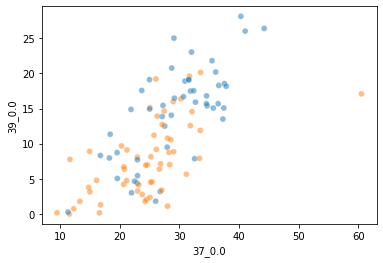

In [19]:
sns.scatterplot(pheno['37_0.0'], pheno['39_0.0'], 
                hue='QTL14', data=pheno, 
                alpha=0.5, legend=None);

In [20]:
## Bring in osmostic phenotypes
osmo = pd.read_csv('../DATA/PHENOTYPE/OSMOTIC/Cdx_osmo_NaCl_1M.csv.gz')
osmo.index = osmo.strain
osmo.head()

,NaCl,strain,rep,column,plate,centroid_r,centroid_c,area,perimeter,major_axis_length,minor_axis_length,eccentricity,equiv_diameter,mean_intensity,solidity,convex_area,bbox_minr,bbox_minc,bbox_maxr,bbox_maxc
strain,,,,,,,,,,,,,,,,,,,,
SS-A837,1.0,SS-A837,1,7.0,2.0,495.787291,650.517175,800.0,107.568543,32.947906,31.152234,0.314415,31.915077,53562.110760,0.962543,831.5,480.5,635.0,513.0,667.5
SS-B307,1.0,SS-B307,1,2.0,2.0,173.576056,1171.969014,710.0,103.396970,31.486114,29.062508,0.384737,30.066594,54714.692487,0.950469,747.0,157.0,1157.0,190.0,1187.0
SS-B308,1.0,SS-B308,1,3.0,2.0,170.336155,1061.388150,827.0,104.911688,33.854111,31.158794,0.391015,32.449485,54093.717050,0.982185,842.0,155.0,1046.0,187.0,1079.0
SS-B310,1.0,SS-B310,1,4.0,2.0,168.746973,960.001211,826.0,107.396970,32.518183,32.374677,0.093844,32.429861,54388.154963,0.971765,850.0,153.0,944.0,187.0,977.0
SS-B311,1.0,SS-B311,1,5.0,2.0,167.589286,852.357143,784.0,103.982756,31.893552,31.328091,0.187470,31.594617,54540.799743,0.972705,806.0,152.0,836.0,184.0,869.0


In [21]:
pheno['NaCl_1M'] = osmo['mean_intensity'].T[pheno.index]

In [22]:
capsule.columns = capsule.columns[:-3].tolist() + [
    'Capsule_diameter_residual','Cell_diameter_residual','QTL']

In [23]:
cap_phenos = [a for a in capsule.columns.tolist() 
              if a not in ['Date','Circles','QTL']]

In [24]:
cap_phenos

['Cell_and_Capsule',
 'Cell',
 'Capsule',
 'Cell_and_Capsule_diameter',
 'Cell_diameter',
 'Capsule_diameter',
 'Capsule_diameter_residual',
 'Cell_diameter_residual']

In [25]:
for p in cap_phenos:
    pheno[p] = np.array(capsule.T[pheno.index].T[p].values,dtype=float)

In [26]:
for p in cap_phenos:
    print(p,ss.pearsonr(*pheno[['Melanin',p]].T.values),'\n')

Cell_and_Capsule (-0.43496037043026575, 3.950140783201283e-06) 

Cell (-0.41519352466162807, 1.1732327876078463e-05) 

Capsule (-0.4096301722562298, 1.574578105728509e-05) 

Cell_and_Capsule_diameter (-0.4440708842242827, 2.336213986657917e-06) 

Cell_diameter (-0.42313663677399915, 7.637856117325205e-06) 

Capsule_diameter (-0.3816515460930577, 6.402467879925427e-05) 

Capsule_diameter_residual (0.1129110847080691, 0.2537831827251009) 

Cell_diameter_residual (-0.09181684799016514, 0.35392919499021175) 



In [27]:
for p in cap_phenos:
    print(p,ss.pearsonr(*pheno[['39_0.0',p]].T.values),'\n')

Cell_and_Capsule (-0.3904313124344341, 4.178814653553261e-05) 

Cell (-0.5094394716486117, 3.3358198859374505e-08) 

Capsule (-0.321126199953331, 0.0008881030648945829) 

Cell_and_Capsule_diameter (-0.41269832140102675, 1.3396001394656102e-05) 

Cell_diameter (-0.5109143016142326, 2.998959078918087e-08) 

Capsule_diameter (-0.27514121733992836, 0.004702117271467614) 

Capsule_diameter_residual (0.3452217319253465, 0.0003319076206579464) 

Cell_diameter_residual (-0.30281659697398494, 0.0017809835685109274) 



In [28]:
pheno_to_analysis = [a for a in pheno.columns.tolist() 
                     if a not in ['QTL14','Cell_and_Capsule','Cell',
                                  'Capsule','Cell_diameter',
                                  'Cell_diameter_residual',
                                 'SSK1','SSK2','RIC8']]

In [29]:
pheno_to_analysis

['Melanin',
 'Fludioxonil',
 'H2O2',
 '30_0.0',
 '30_0.075',
 '30_0.125',
 '30_0.175',
 '37_0.0',
 '37_0.075',
 '37_0.125',
 '37_0.175',
 '39_0.0',
 '39_0.075',
 '39_0.125',
 'NaCl_1M',
 'Cell_and_Capsule_diameter',
 'Capsule_diameter',
 'Capsule_diameter_residual']

In [30]:
pheno_new_names = []
for j in pheno_to_analysis:
    if len(j.split('_')) == 2 and len(j.split('_')[0]) == 2:
        
        if float(j.split('_')[1]) == 0.0:
            k = '0.000'
        else:
            k = j.split('_')[1]
        
        new_name = j.split('_')[0]+'°C & ' + k+u' \u03BCg/ml'
    
    elif j == 'H2O2':
        new_name = 'H$_{2}$O$_{2}$'
    elif j == 'Melanin':
        new_name = 'Melanization'
    elif j == 'Fludioxonil':
        new_name = j + ' 100 \u03BCg/ml'
    elif j[0] == 'C':
        new_name = ' '.join(j.split('_')) 
        new_name = new_name.lower().capitalize()
        if 'diameter' not in new_name:
            new_name = new_name.lower()+' area'
    elif j[0] == 'N' and len(j.split('_')) == 2:
        new_name = ' '.join(j.split('_'))
    else:
        new_name = j.lower().capitalize()
    
    pheno_new_names.append(new_name)

In [31]:
for i,k in enumerate(pheno_new_names):
    
    print(pheno_to_analysis[i],k)

Melanin Melanization
Fludioxonil Fludioxonil 100 μg/ml
H2O2 H$_{2}$O$_{2}$
30_0.0 30°C & 0.000 μg/ml
30_0.075 30°C & 0.075 μg/ml
30_0.125 30°C & 0.125 μg/ml
30_0.175 30°C & 0.175 μg/ml
37_0.0 37°C & 0.000 μg/ml
37_0.075 37°C & 0.075 μg/ml
37_0.125 37°C & 0.125 μg/ml
37_0.175 37°C & 0.175 μg/ml
39_0.0 39°C & 0.000 μg/ml
39_0.075 39°C & 0.075 μg/ml
39_0.125 39°C & 0.125 μg/ml
NaCl_1M NaCl 1M
Cell_and_Capsule_diameter Cell and capsule diameter
Capsule_diameter Capsule diameter
Capsule_diameter_residual Capsule diameter residual


In [32]:
pheno['Melanin'] = -pheno['Melanin']

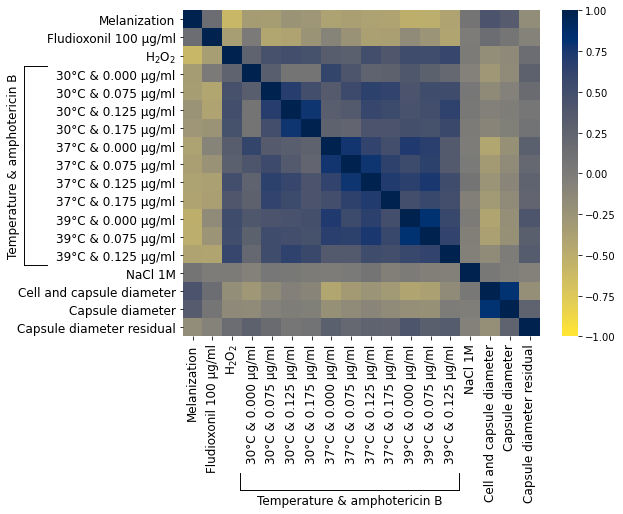

In [33]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.heatmap( pheno[pheno_to_analysis].corr(method='spearman'),
            vmin = -1, vmax=1,cmap='cividis_r');
fs = 12
xticks = plt.xticks()[0]
plt.xticks(xticks,pheno_new_names,fontsize=fs);
yticks = plt.yticks()[0]
plt.yticks(yticks,pheno_new_names,fontsize=fs);

x1 = -0.15
fig.add_axes([x1,0.29,0.0001,.46])
plt.xticks([]);plt.yticks([]);
plt.ylabel('Temperature & amphotericin B',fontsize=fs)
fig.add_axes([x1,0.29,0.04,0.0001])
plt.xticks([]);plt.yticks([]);
fig.add_axes([x1,.75,0.04,0.0001])
plt.xticks([]);plt.yticks([]);

y1 = -0.23
x2 = 0.225
fig.add_axes([x2,y1,0.38,.00001])
plt.xticks([]);plt.yticks([]);
plt.xlabel('Temperature & amphotericin B',fontsize=fs)
fig.add_axes([x2,y1,0.0001,0.04])
plt.xticks([]);plt.yticks([]);
fig.add_axes([x2+.38,y1,0.0001,0.04])
plt.xticks([]);plt.yticks([]);

#plt.savefig('./Phenotypes_corrilation_plot.png',
plt.savefig('../FIGURES/SUPP/PDFs/S8_Fig.pdf',
                dpi=300,bbox_inches='tight');

In [34]:
for_pm = np.array(pheno_to_analysis)[[0,2,11,-1]]

In [35]:
pm_new_names = np.array(pheno_new_names)[[0,2,11,-1]]

In [36]:
#pheno['Melanin'] = -1*pheno['Melanin']

In [37]:
pheno[for_pm].corr(method='spearman')

,Melanin,H2O2,39_0.0,Capsule_diameter_residual
Melanin,1.000000,-0.589647,-0.512184,-0.185778
H2O2,-0.589647,1.000000,0.527965,0.150154
39_0.0,-0.512184,0.527965,1.000000,0.427152
Capsule_diameter_residual,-0.185778,0.150154,0.427152,1.000000


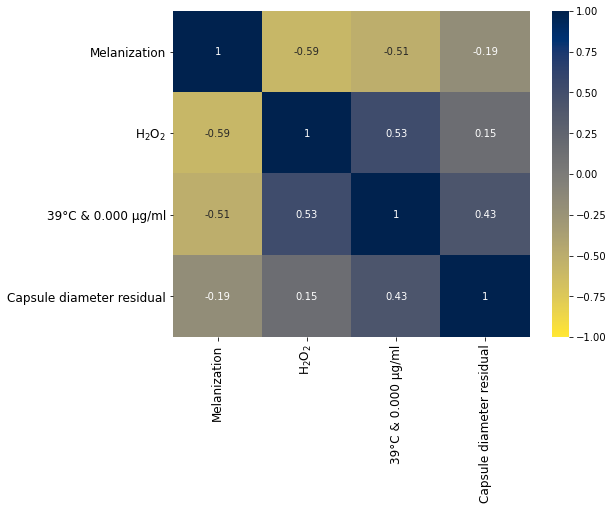

In [38]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.heatmap( pheno[for_pm].corr(method='spearman'),
            vmin = -1, vmax=1,cmap='cividis_r',annot=True);
fs = 12
xticks = plt.xticks()[0]
plt.xticks(xticks,pm_new_names,fontsize=fs,rotation=90);
yticks = plt.yticks()[0]
plt.yticks(yticks,pm_new_names,fontsize=fs,rotation=0);
#plt.savefig('./Phenotypes_corrilation_for_PM.png',
#                dpi=200,bbox_inches='tight');

In [39]:
#assert 1 == 0

In [40]:
from mpl_toolkits import mplot3d

In [41]:
qtlloci = pd.read_csv('~/Desktop/Cdx_QTL_SNPs.csv',index_col=0)

In [42]:
pheno['RIC8'] = qtlloci[(qtlloci.Chrom=='Chr14')][pheno.index].values[0]
pheno['SSK1'] = qtlloci[(qtlloci.Chrom=='Chr02')][pheno.index].values[0]
pheno['SSK2'] = qtlloci[(qtlloci.Chrom=='Chr12')][pheno.index].values[0]

In [43]:
pheno.tail()

,Melanin,Fludioxonil,H2O2,30_0.0,30_0.075,30_0.125,30_0.175,37_0.0,37_0.075,37_0.125,...,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Capsule_diameter_residual,Cell_diameter_residual,RIC8,SSK1,SSK2
SS-C272,-8753.444667,1.0,3.75,43.949125,24.359000,15.252375,9.834250,25.19600,8.879825,5.822625,...,988.0,2137.0,63.078313,35.467741,27.610572,3.566843,-3.644873,1.0,1.0,0.0
SS-C290,-12548.160000,1.0,4.00,68.294250,10.636000,8.575750,3.587625,33.49700,9.221500,1.456500,...,1198.0,1930.5,63.315088,39.025500,25.013997,0.825720,-0.172045,1.0,1.0,1.0
SS-C291,-18622.775333,1.0,3.75,71.006875,14.759000,6.783250,1.210525,29.16125,9.942000,0.847625,...,793.5,2107.5,63.490758,31.756646,28.236088,3.940567,-7.503911,0.0,1.0,1.0
XL280a,-18894.701000,1.0,4.50,40.878300,33.301625,24.437825,13.611125,28.70725,20.095050,11.984250,...,716.0,1891.0,57.769972,30.193369,26.845469,6.042420,-7.015166,0.0,0.0,0.0
XL280alpha,-19862.037333,1.0,4.50,63.921375,21.777500,21.991725,8.052000,34.54725,27.192050,14.541025,...,1522.0,2428.0,67.307499,44.018505,29.304001,2.678405,3.388899,0.0,0.0,0.0


In [44]:
pheno['new_mosaic'] = -1

for c,(i,a) in enumerate(pheno.groupby(['SSK2','RIC8'])):
    
    pheno.loc[a.index,'new_mosaic'] = c

In [45]:
assert pheno.new_mosaic.min()!=-1

In [46]:
new_mosaic = pheno[['RIC8','SSK2','new_mosaic']].drop_duplicates().sort_values('new_mosaic').reset_index(drop=True).copy()
new_mosaic

,RIC8,SSK2,new_mosaic
0,0.0,0.0,0
1,1.0,0.0,1
2,0.0,1.0,2
3,1.0,1.0,3


In [47]:
new_xlabel = '$SSK2$: %s\n$RIC8$: %s'
parental_label = [xl280_label,_431_label]
new_xlabels = []

for i,j in new_mosaic.iterrows():
    
    new_xlabels.append(new_xlabel%(parental_label[int(j.SSK2)],parental_label[int(j.RIC8)]))
new_xlabels

['$SSK2$: XL280$\\bf{a}$\n$RIC8$: XL280$\\bf{a}$',
 '$SSK2$: XL280$\\bf{a}$\n$RIC8$: 431$\\mathrm{\\alpha}$',
 '$SSK2$: 431$\\mathrm{\\alpha}$\n$RIC8$: XL280$\\bf{a}$',
 '$SSK2$: 431$\\mathrm{\\alpha}$\n$RIC8$: 431$\\mathrm{\\alpha}$']

In [48]:
pheno['Melanin'] = pheno['Melanin'].apply(np.abs)
pheno['SSK1r'] = pheno['SSK1'].replace(dict(zip([0,1],[xl280_label,_431_label])))

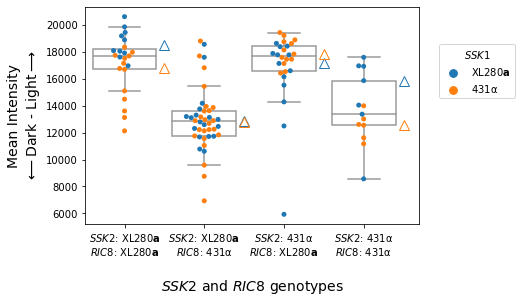

In [49]:
sns.boxplot(x='new_mosaic',y='Melanin',data=pheno,color='w',showfliers = False)
sns.swarmplot(x='new_mosaic',y='Melanin',hue='SSK1r',
              data=pheno,hue_order=[xl280_label,_431_label]);
plt.legend(title='$SSK1$',bbox_to_anchor=(1.3,.85),fontsize=10)
plt.xlabel('\n$SSK2$ and $RIC8$ genotypes',fontsize=14)
plt.xticks(np.arange(0,4),new_xlabels,fontsize=10);
plt.ylabel('Mean Intensity\n$\longleftarrow$Dark - Light$\longrightarrow$',fontsize=14);

for i,j in pheno.groupby(['new_mosaic','SSK1']):
    
    plt.plot(i[0]+0.5,j.Melanin.median(),'^',ms =10,
             fillstyle='none',color='tab:blue' if i[1] == 0 else 'tab:orange')
plt.xlim(-0.5,3.7);
#plt.savefig('/home/croth/Desktop/Melanization_RIC8:SSK2_by_SSK1.png',
#            dpi=100,bbox_inches='tight');

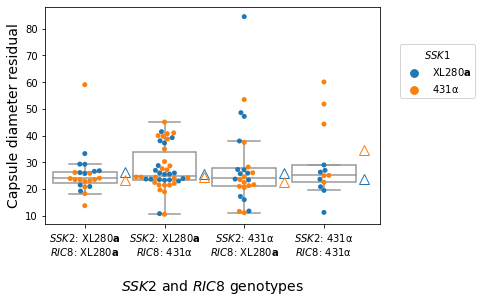

In [50]:
sns.boxplot(x='new_mosaic',y='Capsule_diameter',data=pheno,color='w',showfliers = False)
sns.swarmplot(x='new_mosaic',y='Capsule_diameter',hue='SSK1r',
              data=pheno,hue_order=[xl280_label,_431_label]);
plt.legend(title='$SSK1$',bbox_to_anchor=(1.3,.85),fontsize=10)
plt.xlabel('\n$SSK2$ and $RIC8$ genotypes',fontsize=14)
plt.xticks(np.arange(0,4),new_xlabels,fontsize=10);
plt.ylabel('Capsule diameter residual',fontsize=14);

for i,j in pheno.groupby(['new_mosaic','SSK1']):
    
    plt.plot(i[0]+0.5,j.Capsule_diameter.median(),'^',ms =10,
             fillstyle='none',color='tab:blue' if i[1] == 0 else 'tab:orange')
plt.xlim(-0.5,3.7);
#plt.savefig('/home/croth/Desktop/Capsule_diameter_RIC8:SSK2_by_SSK1.png',
#            dpi=100,bbox_inches='tight');

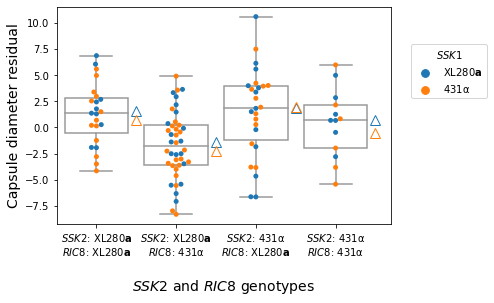

In [51]:
sns.boxplot(x='new_mosaic',y='Capsule_diameter_residual',data=pheno,color='w',showfliers = False)
sns.swarmplot(x='new_mosaic',y='Capsule_diameter_residual',hue='SSK1r',
              data=pheno,hue_order=[xl280_label,_431_label]);
plt.legend(title='$SSK1$',bbox_to_anchor=(1.3,.85),fontsize=10)
plt.xlabel('\n$SSK2$ and $RIC8$ genotypes',fontsize=14)
plt.xticks(np.arange(0,4),new_xlabels,fontsize=10);
plt.ylabel('Capsule diameter residual',fontsize=14);

for i,j in pheno.groupby(['new_mosaic','SSK1']):
    
    plt.plot(i[0]+0.5,j.Capsule_diameter_residual.median(),'^',ms =10,
             fillstyle='none',color='tab:blue' if i[1] == 0 else 'tab:orange')
plt.xlim(-0.5,3.7);
#plt.savefig('/home/croth/Desktop/Capsule_diameter_residual_RIC8:SSK2_by_SSK1.png',
#            dpi=100,bbox_inches='tight');

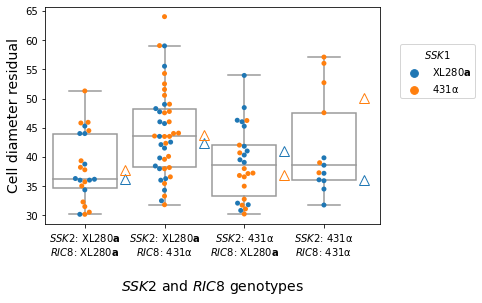

In [52]:
sns.boxplot(x='new_mosaic',y='Cell_diameter',data=pheno,color='w',showfliers = False)
sns.swarmplot(x='new_mosaic',y='Cell_diameter',hue='SSK1r',
              data=pheno,hue_order=[xl280_label,_431_label]);
plt.legend(title='$SSK1$',bbox_to_anchor=(1.3,.85),fontsize=10)
plt.xlabel('\n$SSK2$ and $RIC8$ genotypes',fontsize=14)
plt.xticks(np.arange(0,4),new_xlabels,fontsize=10);
plt.ylabel('Cell diameter residual',fontsize=14);

for i,j in pheno.groupby(['new_mosaic','SSK1']):
    
    plt.plot(i[0]+0.5,j.Cell_diameter.median(),'^',ms =10,
             fillstyle='none',color='tab:blue' if i[1] == 0 else 'tab:orange')
plt.xlim(-0.5,3.7);
#plt.savefig('/home/croth/Desktop/Cell_diameter_RIC8:SSK2_by_SSK1.png',
#            dpi=100,bbox_inches='tight');

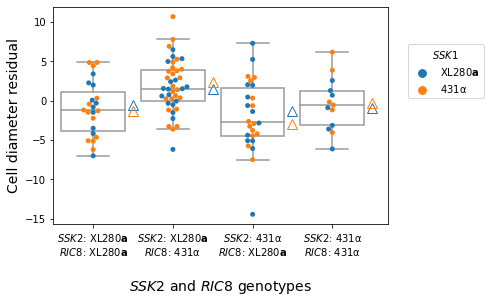

In [53]:
sns.boxplot(x='new_mosaic',y='Cell_diameter_residual',data=pheno,color='w',showfliers = False)
sns.swarmplot(x='new_mosaic',y='Cell_diameter_residual',hue='SSK1r',
              data=pheno,hue_order=[xl280_label,_431_label]);
plt.legend(title='$SSK1$',bbox_to_anchor=(1.3,.85),fontsize=10)
plt.xlabel('\n$SSK2$ and $RIC8$ genotypes',fontsize=14)
plt.xticks(np.arange(0,4),new_xlabels,fontsize=10);
plt.ylabel('Cell diameter residual',fontsize=14);

for i,j in pheno.groupby(['new_mosaic','SSK1']):
    
    plt.plot(i[0]+0.5,j.Cell_diameter_residual.median(),'^',ms =10,
             fillstyle='none',color='tab:blue' if i[1] == 0 else 'tab:orange')
plt.xlim(-0.5,3.7);
#plt.savefig('/home/croth/Desktop/Cell_diameter_residual_RIC8:SSK2_by_SSK1.png',
#            dpi=100,bbox_inches='tight');

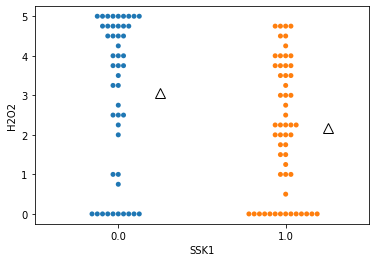

In [54]:
sns.swarmplot(x='SSK1',y='H2O2',data=pheno);
plt.plot(np.array([0,1])+.25, pheno.groupby('SSK1')['H2O2'].mean().values,'k^',fillstyle='none',ms=10);
#plt.savefig('/home/croth/Desktop/H2O2_bySSK1.png',dpi=100,bbox_inches='tight');


In [55]:
pheno.groupby('SSK1')['H2O2'].mean()

SSK1
0.0    3.046875
1.0    2.174107
Name: H2O2, dtype: float64

In [56]:
pheno['SSK2r'] = pheno['SSK2'].replace(dict(zip([0,1],[xl280_label,_431_label])))
pheno['RIC8r'] = pheno['RIC8'].replace(dict(zip([0,1],[xl280_label,_431_label])))

In [57]:
for i,a in enumerate(pheno.groupby(['SSK1','SSK2'])):
    
    pheno.loc[a[1].index,'new_mosaic'] = i

In [58]:
pheno[['SSK1','SSK2','new_mosaic']].drop_duplicates().sort_values(['SSK1','SSK2'])

,SSK1,SSK2,new_mosaic
SS-B307,0.0,0.0,0
SS-B311,0.0,1.0,1
SS-B310,1.0,0.0,2
SS-A837,1.0,1.0,3


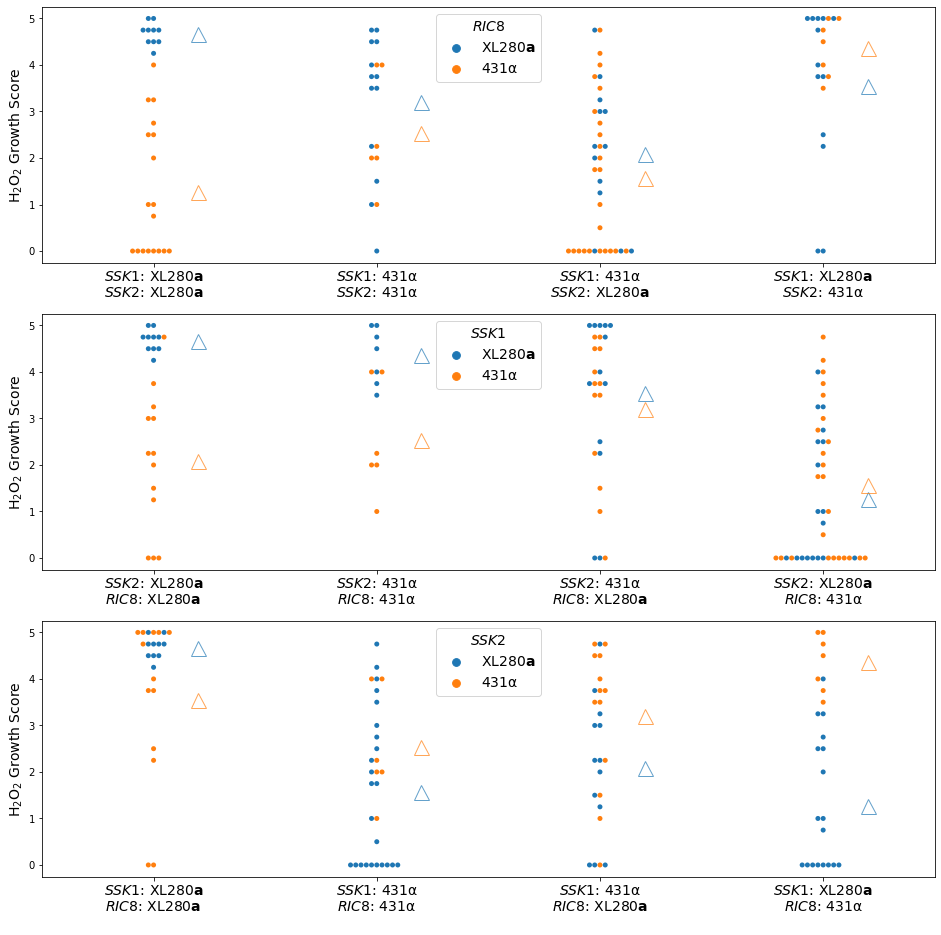

In [59]:
myphenooi = 'H2O2'
myylabel = 'H$_{2}$O$_{2}$ Growth Score'
fig, ax = plt.subplots(3,1,figsize=(16,16),sharex=False,sharey=True)

for ri,px in enumerate([('SSK1','SSK2','RIC8'),('SSK2','RIC8','SSK1'),('SSK1','RIC8','SSK2')]):
    
    g0 = px[0]
    g1 = px[1]
    g2 = px[2]

    pheno['new_mosaic'] = -1
    for i,a in enumerate(pheno.groupby([g0,g1])):
        pheno.loc[a[1].index,'new_mosaic'] = i
    
    temp_mosaic = pheno[(pheno[g0]==1) & (pheno[g1]==1)].new_mosaic.min()
    pheno.loc[(pheno[g0]==1) & (pheno[g1]==1),'new_mosaic'] = -temp_mosaic
    pheno.loc[(pheno.new_mosaic==1),'new_mosaic'] = temp_mosaic
    pheno.loc[(pheno.new_mosaic==-temp_mosaic),'new_mosaic'] = 1
    assert pheno.new_mosaic.min()>=0
    new_mosaic_df = pheno[[g0,g1,'new_mosaic']].drop_duplicates().sort_values('new_mosaic').copy()

    plt.sca(ax[ri])
    sns.swarmplot(x='new_mosaic',y=myphenooi,data=pheno,hue='%sr'%g2,
              hue_order=[xl280_label,_431_label]);
    lg = plt.legend(bbox_to_anchor=(0.5,0.68),title='$%s$'%g2,fontsize=14);
    title = lg.get_title()
    title.set_fontsize(14)
    plt.ylabel(myylabel,fontsize=14)

    mean_scores = pheno.groupby(['new_mosaic',g2]).mean()
    for i,j in mean_scores.iterrows():
        plt.plot(i[0]+0.2,j[myphenooi],'^',ms = 15,fillstyle='none',
             color='tab:blue' if i[1] == 0 else 'tab:orange',alpha=0.69);

    xlabel = '$%s$: %s\n$%s$: %s'
    new_x_labels = []

    for i,j in new_mosaic_df.iterrows():
    
        xlab = xlabel%(g0,parental_label[int(j[g0])],g1,parental_label[int(j[g1])])
        new_x_labels.append(xlab)
    
    plt.xticks(np.arange(0,4),new_x_labels,fontsize=14);
    plt.xlabel(' ')
#plt.savefig('/home/croth/Desktop/Parametric/%s_bygeno.png'%myphenooi,
#            bbox_inches='tight',dpi=200);

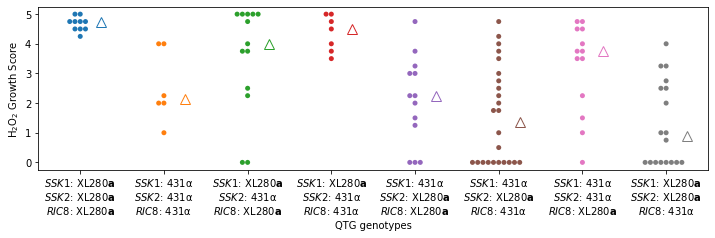

In [60]:
pheno['new_mosaic'] = -1
for i,a in enumerate(pheno.groupby(['SSK1','SSK2','RIC8'])):
    
    pheno.loc[a[1].index,'new_mosaic'] = i
    
temp_mosaic = pheno[(pheno.RIC8==1) & (pheno.SSK2==1) & (pheno.SSK1==1)].new_mosaic.min()

pheno.loc[(pheno.RIC8==1) & (pheno.SSK2==1) & (pheno.SSK1==1),'new_mosaic'] = -temp_mosaic

pheno.loc[(pheno.new_mosaic==1),'new_mosaic'] = temp_mosaic
pheno.loc[(pheno.new_mosaic==-temp_mosaic),'new_mosaic'] = 1

assert pheno.new_mosaic.min()>=0

new_mosaic_df = pheno[['SSK1','SSK2','RIC8','new_mosaic']].drop_duplicates().sort_values('new_mosaic').copy()

xlabel = '$SSK1$: %s\n$SSK2$: %s\n$RIC8$: %s'
new_x_labels = []

for i,j in new_mosaic_df.iterrows():
    
    xlab = xlabel%(parental_label[int(j.SSK1)],parental_label[int(j.SSK2)],parental_label[int(j.RIC8)])
    new_x_labels.append(xlab)
    
fig,ax= plt.subplots(1,1,figsize=(12,3))
#sns.boxplot(x='new_mosaic',y='H2O2',data=pheno,color='w')
sns.swarmplot(x='new_mosaic',y='H2O2',data=pheno);

for i,j in pheno.groupby('new_mosaic'):
    
    plt.plot(i+.25,j.H2O2.median(),'^',fillstyle='none',ms=10)

plt.ylabel('H$_{2}$O$_{2}$ Growth Score')
plt.xlabel('QTG genotypes')
plt.xticks(new_mosaic_df.new_mosaic,new_x_labels,fontsize=10);
#plt.savefig('/home/croth/Desktop/H2O2_all_combos.png',dpi=100,bbox_inches='tight');

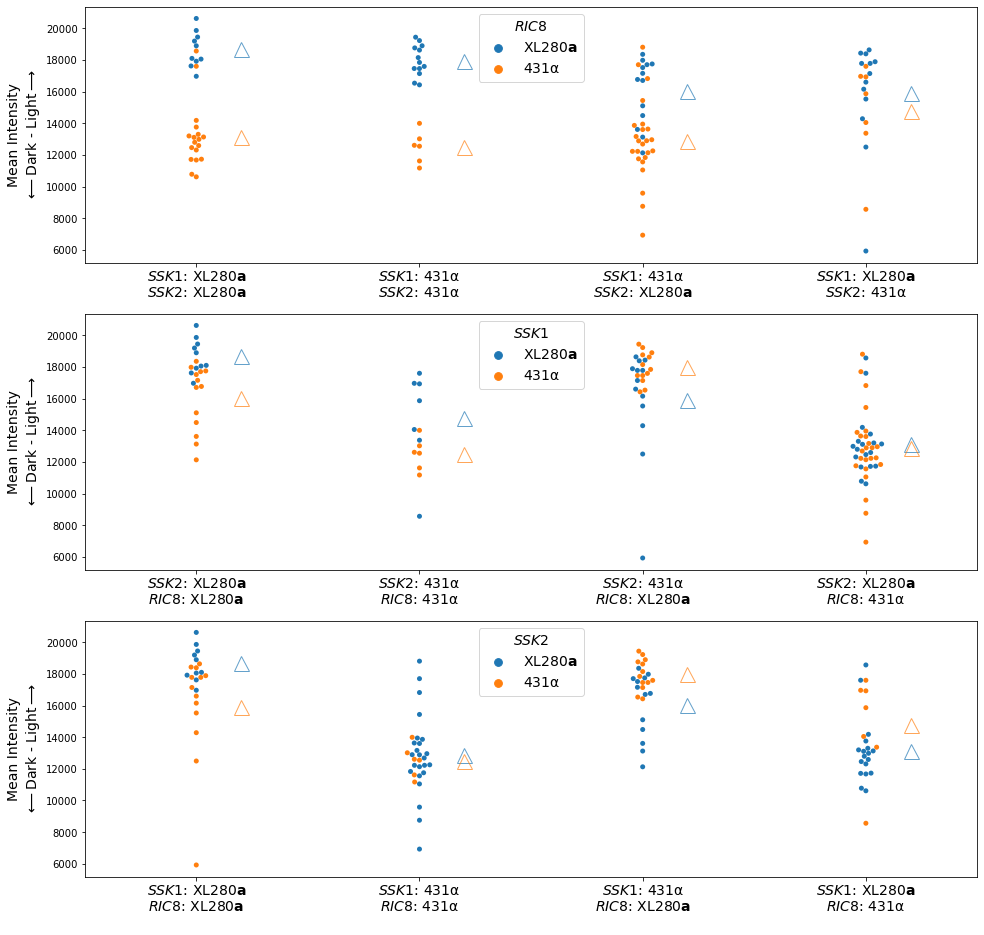

In [61]:
myphenooi = 'Melanin'
myylabel = 'Mean Intensity\n$\longleftarrow$Dark - Light$\longrightarrow$'#'H$_{2}$O$_{2}$ Growth Score'
fig, ax = plt.subplots(3,1,figsize=(16,16),sharex=False,sharey=True)

for ri,px in enumerate([('SSK1','SSK2','RIC8'),('SSK2','RIC8','SSK1'),('SSK1','RIC8','SSK2')]):
    
    g0 = px[0]
    g1 = px[1]
    g2 = px[2]

    pheno['new_mosaic'] = -1
    for i,a in enumerate(pheno.groupby([g0,g1])):
        pheno.loc[a[1].index,'new_mosaic'] = i
    
    temp_mosaic = pheno[(pheno[g0]==1) & (pheno[g1]==1)].new_mosaic.min()
    pheno.loc[(pheno[g0]==1) & (pheno[g1]==1),'new_mosaic'] = -temp_mosaic
    pheno.loc[(pheno.new_mosaic==1),'new_mosaic'] = temp_mosaic
    pheno.loc[(pheno.new_mosaic==-temp_mosaic),'new_mosaic'] = 1
    assert pheno.new_mosaic.min()>=0
    new_mosaic_df = pheno[[g0,g1,'new_mosaic']].drop_duplicates().sort_values('new_mosaic').copy()

    plt.sca(ax[ri])
    sns.swarmplot(x='new_mosaic',y=myphenooi,data=pheno,hue='%sr'%g2,
              hue_order=[xl280_label,_431_label]);
    lg = plt.legend(bbox_to_anchor=(0.5,0.68),title='$%s$'%g2,fontsize=14);
    title = lg.get_title()
    title.set_fontsize(14)
    plt.ylabel(myylabel,fontsize=14)

    mean_scores = pheno.groupby(['new_mosaic',g2]).mean()
    for i,j in mean_scores.iterrows():
        plt.plot(i[0]+0.2,j[myphenooi],'^',ms = 15,fillstyle='none',
             color='tab:blue' if i[1] == 0 else 'tab:orange',alpha=0.69);

    xlabel = '$%s$: %s\n$%s$: %s'
    new_x_labels = []

    for i,j in new_mosaic_df.iterrows():
    
        xlab = xlabel%(g0,parental_label[int(j[g0])],g1,parental_label[int(j[g1])])
        new_x_labels.append(xlab)
    
    plt.xticks(np.arange(0,4),new_x_labels,fontsize=14);
    plt.xlabel(' ')
#plt.savefig('/home/croth/Desktop/Parametric/%s_bygeno.png'%myphenooi,
#            bbox_inches='tight',dpi=200);

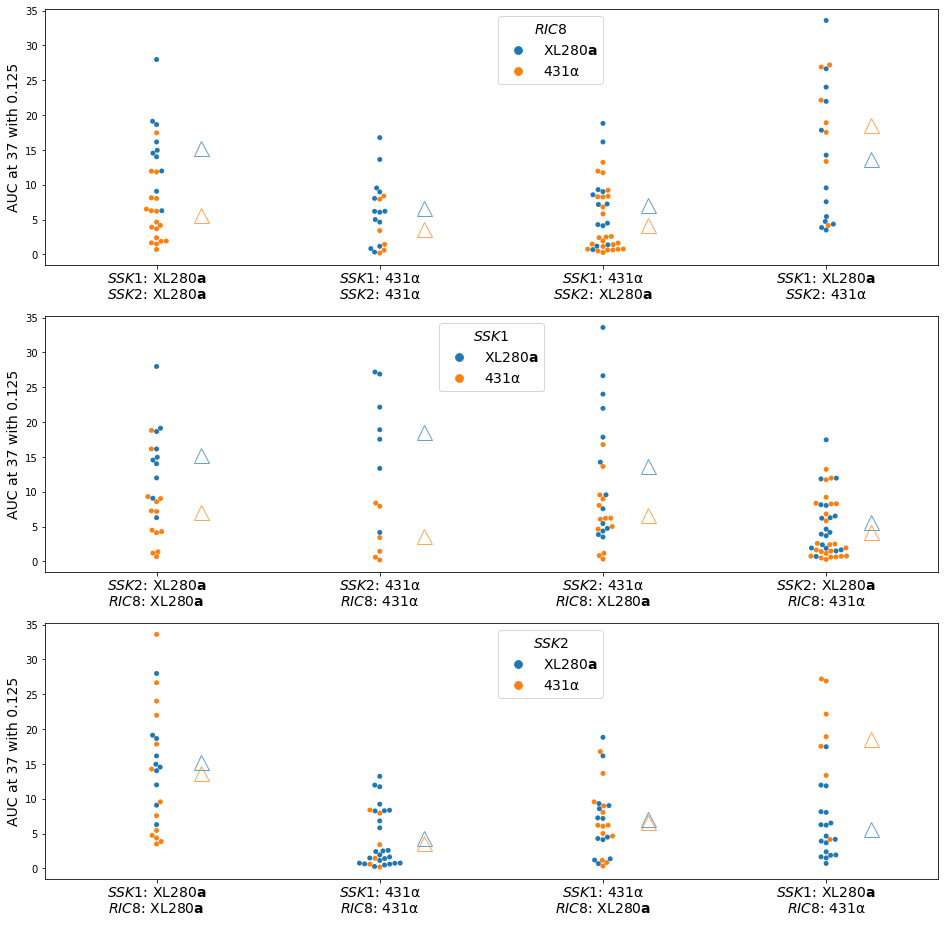

In [62]:
myphenooi = '37_0.125'
myylabel = 'AUC at 37 with 0.125'
fig, ax = plt.subplots(3,1,figsize=(16,16),sharex=False,sharey=True)

for ri,px in enumerate([('SSK1','SSK2','RIC8'),('SSK2','RIC8','SSK1'),('SSK1','RIC8','SSK2')]):
    
    g0 = px[0]
    g1 = px[1]
    g2 = px[2]

    pheno['new_mosaic'] = -1
    for i,a in enumerate(pheno.groupby([g0,g1])):
        pheno.loc[a[1].index,'new_mosaic'] = i
    
    temp_mosaic = pheno[(pheno[g0]==1) & (pheno[g1]==1)].new_mosaic.min()
    pheno.loc[(pheno[g0]==1) & (pheno[g1]==1),'new_mosaic'] = -temp_mosaic
    pheno.loc[(pheno.new_mosaic==1),'new_mosaic'] = temp_mosaic
    pheno.loc[(pheno.new_mosaic==-temp_mosaic),'new_mosaic'] = 1
    assert pheno.new_mosaic.min()>=0
    new_mosaic_df = pheno[[g0,g1,'new_mosaic']].drop_duplicates().sort_values('new_mosaic').copy()

    plt.sca(ax[ri])
    sns.swarmplot(x='new_mosaic',y=myphenooi,data=pheno,hue='%sr'%g2,
              hue_order=[xl280_label,_431_label]);
    lg = plt.legend(bbox_to_anchor=(0.5,0.68),title='$%s$'%g2,fontsize=14);
    title = lg.get_title()
    title.set_fontsize(14)
    plt.ylabel(myylabel,fontsize=14)

    mean_scores = pheno.groupby(['new_mosaic',g2]).mean()
    for i,j in mean_scores.iterrows():
        plt.plot(i[0]+0.2,j[myphenooi],'^',ms = 15,fillstyle='none',
             color='tab:blue' if i[1] == 0 else 'tab:orange',alpha=0.69);

    xlabel = '$%s$: %s\n$%s$: %s'
    new_x_labels = []

    for i,j in new_mosaic_df.iterrows():
    
        xlab = xlabel%(g0,parental_label[int(j[g0])],g1,parental_label[int(j[g1])])
        new_x_labels.append(xlab)
    
    plt.xticks(np.arange(0,4),new_x_labels,fontsize=14);
    plt.xlabel(' ')
#plt.savefig('/home/croth/Desktop/Parametric/%s_bygeno.png'%myphenooi,
#            bbox_inches='tight',dpi=200);

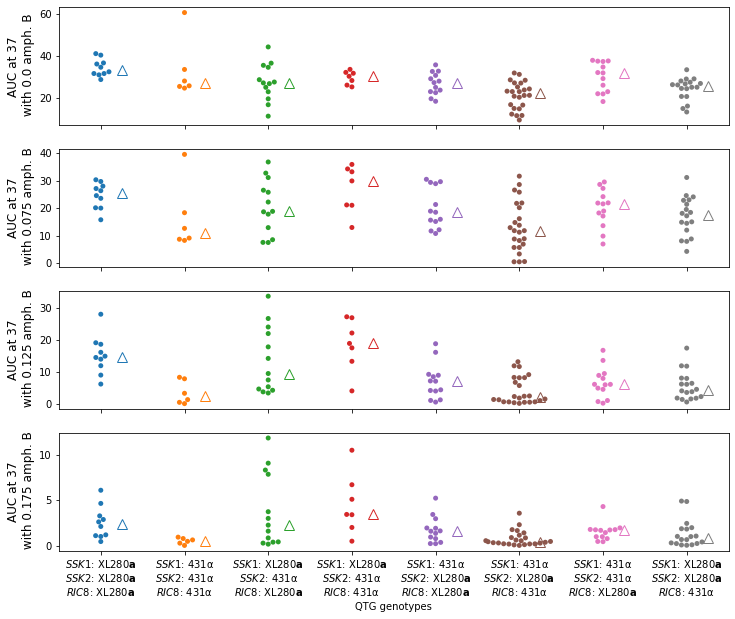

In [63]:
pheno['new_mosaic'] = -1
for i,a in enumerate(pheno.groupby(['SSK1','SSK2','RIC8'])):
    
    pheno.loc[a[1].index,'new_mosaic'] = i
    
temp_mosaic = pheno[(pheno.RIC8==1) & (pheno.SSK2==1) & (pheno.SSK1==1)].new_mosaic.min()

pheno.loc[(pheno.RIC8==1) & (pheno.SSK2==1) & (pheno.SSK1==1),'new_mosaic'] = -temp_mosaic

pheno.loc[(pheno.new_mosaic==1),'new_mosaic'] = temp_mosaic
pheno.loc[(pheno.new_mosaic==-temp_mosaic),'new_mosaic'] = 1

assert pheno.new_mosaic.min()>=0

new_mosaic_df = pheno[['SSK1','SSK2','RIC8','new_mosaic']].drop_duplicates().sort_values('new_mosaic').copy()

xlabel = '$SSK1$: %s\n$SSK2$: %s\n$RIC8$: %s'
new_x_labels = []

for i,j in new_mosaic_df.iterrows():
    
    xlab = xlabel%(parental_label[int(j.SSK1)],parental_label[int(j.SSK2)],parental_label[int(j.RIC8)])
    new_x_labels.append(xlab)
    

growth_curves = ['37_%s'%d for d in [0.0,0.075,0.125,0.175]]

fig,ax= plt.subplots(len(growth_curves),1,figsize=(12,10),sharex=True)
#sns.boxplot(x='new_mosaic',y='H2O2',data=pheno,color='w')
for ix,pt in enumerate(growth_curves):
    plt.sca(ax[ix])
    sns.swarmplot(x='new_mosaic',y=pt, data=pheno);

    for i,j in pheno.groupby('new_mosaic'):
    
        plt.plot(i+.25,j[pt].median(),'^',fillstyle='none',ms=10)

    plt.ylabel('AUC at %s\n with %s amph. B'%(pt.split('_')[0],pt.split('_')[1]),fontsize=12)
    plt.xlabel('')
plt.xlabel('QTG genotypes')
plt.xticks(new_mosaic_df.new_mosaic,new_x_labels,fontsize=10);
#plt.savefig('/home/croth/Desktop/Drug_curves_37C_all_combos.png',
#            dpi=100,bbox_inches='tight');

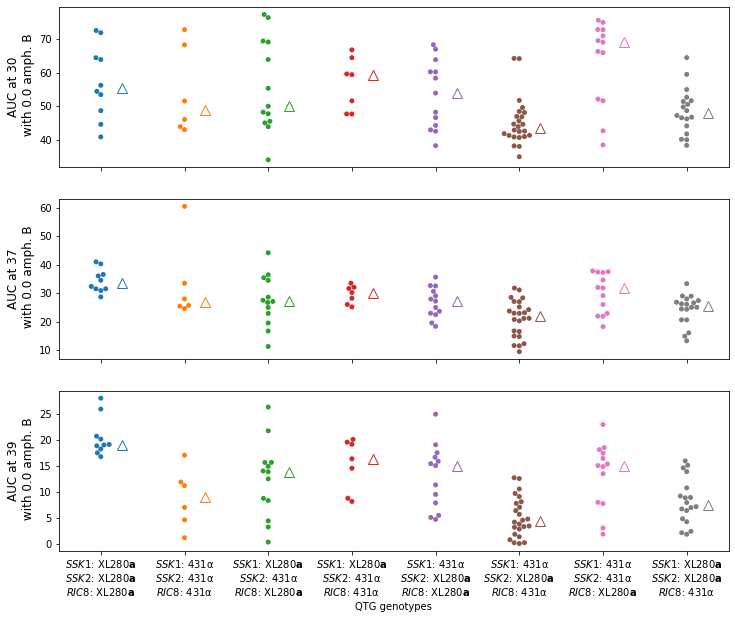

In [64]:
pheno['new_mosaic'] = -1
for i,a in enumerate(pheno.groupby(['SSK1','SSK2','RIC8'])):
    
    pheno.loc[a[1].index,'new_mosaic'] = i
    
temp_mosaic = pheno[(pheno.RIC8==1) & (pheno.SSK2==1) & (pheno.SSK1==1)].new_mosaic.min()

pheno.loc[(pheno.RIC8==1) & (pheno.SSK2==1) & (pheno.SSK1==1),'new_mosaic'] = -temp_mosaic

pheno.loc[(pheno.new_mosaic==1),'new_mosaic'] = temp_mosaic
pheno.loc[(pheno.new_mosaic==-temp_mosaic),'new_mosaic'] = 1

assert pheno.new_mosaic.min()>=0

new_mosaic_df = pheno[['SSK1','SSK2','RIC8','new_mosaic']].drop_duplicates().sort_values('new_mosaic').copy()

xlabel = '$SSK1$: %s\n$SSK2$: %s\n$RIC8$: %s'
new_x_labels = []

for i,j in new_mosaic_df.iterrows():
    
    xlab = xlabel%(parental_label[int(j.SSK1)],parental_label[int(j.SSK2)],parental_label[int(j.RIC8)])
    new_x_labels.append(xlab)
    

growth_curves = ['%d_0.0'%d for d in [30,37,39]]

fig,ax= plt.subplots(len(growth_curves),1,figsize=(12,10),sharex=True)
#sns.boxplot(x='new_mosaic',y='H2O2',data=pheno,color='w')
for ix,pt in enumerate(growth_curves):
    plt.sca(ax[ix])
    sns.swarmplot(x='new_mosaic',y=pt, data=pheno);

    for i,j in pheno.groupby('new_mosaic'):
    
        plt.plot(i+.25,j[pt].median(),'^',fillstyle='none',ms=10)

    plt.ylabel('AUC at %s\n with %s amph. B'%(pt.split('_')[0],pt.split('_')[1]),fontsize=12)
    plt.xlabel('')
plt.xlabel('QTG genotypes')
plt.xticks(new_mosaic_df.new_mosaic,new_x_labels,fontsize=10);
#plt.savefig('/home/croth/Desktop/temperature_curves_no_drug_amph.B_all_combos.png',
#            dpi=100,bbox_inches='tight');

/home/croth/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/croth/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


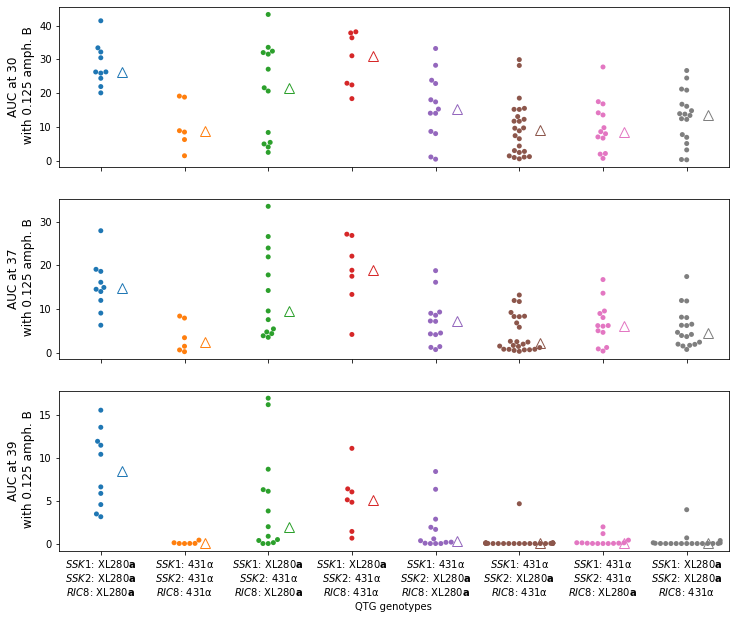

In [65]:
pheno['new_mosaic'] = -1
for i,a in enumerate(pheno.groupby(['SSK1','SSK2','RIC8'])):
    
    pheno.loc[a[1].index,'new_mosaic'] = i
    
temp_mosaic = pheno[(pheno.RIC8==1) & (pheno.SSK2==1) & (pheno.SSK1==1)].new_mosaic.min()

pheno.loc[(pheno.RIC8==1) & (pheno.SSK2==1) & (pheno.SSK1==1),'new_mosaic'] = -temp_mosaic

pheno.loc[(pheno.new_mosaic==1),'new_mosaic'] = temp_mosaic
pheno.loc[(pheno.new_mosaic==-temp_mosaic),'new_mosaic'] = 1

assert pheno.new_mosaic.min()>=0

new_mosaic_df = pheno[['SSK1','SSK2','RIC8','new_mosaic']].drop_duplicates().sort_values('new_mosaic').copy()

xlabel = '$SSK1$: %s\n$SSK2$: %s\n$RIC8$: %s'
new_x_labels = []

for i,j in new_mosaic_df.iterrows():
    
    xlab = xlabel%(parental_label[int(j.SSK1)],parental_label[int(j.SSK2)],parental_label[int(j.RIC8)])
    new_x_labels.append(xlab)
    

growth_curves = ['%d_0.125'%d for d in [30,37,39]]

fig,ax= plt.subplots(len(growth_curves),1,figsize=(12,10),sharex=True)
#sns.boxplot(x='new_mosaic',y='H2O2',data=pheno,color='w')
for ix,pt in enumerate(growth_curves):
    plt.sca(ax[ix])
    sns.swarmplot(x='new_mosaic',y=pt, data=pheno);

    for i,j in pheno.groupby('new_mosaic'):
    
        plt.plot(i+.25,j[pt].median(),'^',fillstyle='none',ms=10)

    plt.ylabel('AUC at %s\n with %s amph. B'%(pt.split('_')[0],pt.split('_')[1]),fontsize=12)
    plt.xlabel('')
plt.xlabel('QTG genotypes')
plt.xticks(new_mosaic_df.new_mosaic,new_x_labels,fontsize=10);
#plt.savefig('/home/croth/Desktop/temperature_curves_0.125_amph.B_all_combos.png',
#            dpi=100,bbox_inches='tight');

In [66]:
import statsmodels.formula.api as smf

In [67]:
pheno['AUC37'] = pheno['37_0.125']

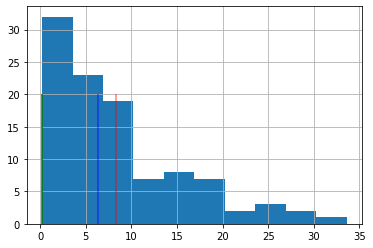

In [68]:
pheno['AUC37'].hist()
plt.vlines(pheno['AUC37'].median(),0,20,'b',alpha=0.5)
plt.vlines(pheno['AUC37'].mean(),0,20,'r',alpha=0.5)
plt.vlines(ss.mode(pheno['AUC37'].values,axis=None)[0][0],0,20,'g');

In [69]:
ss.normaltest(np.sqrt(pheno.AUC37.values))

NormaltestResult(statistic=5.237869920860348, pvalue=0.07288044206228766)

In [70]:
pheno['AUC_37'] = np.sqrt(pheno.AUC37.values)

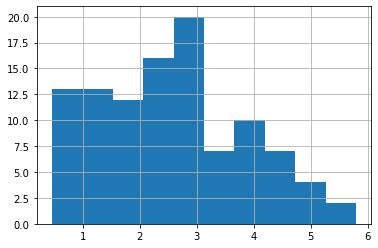

In [71]:
pheno.AUC_37.hist();

In [72]:
smf.ols('AUC_37~SSK1+SSK2 + RIC8',data=pheno).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 AUC_37   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     12.67
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           4.36e-07
Time:                        14:44:07   Log-Likelihood:                -156.48
No. Observations:                 104   AIC:                             321.0
Df Residuals:                     100   BIC:                             331.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3950      0.238     14.240      0.000       2.922       3.868
SSK1          -1.0627      0.219     -4.847      0.000      -1.498      -0.628
SSK2           0.2956      0.237      1.248      0.215      -0.174       0.766
RIC8          -0.6484      0.229     -2.831      0.006      -1.103      -0.194
==============================================================================
Omnibus:                       11.382   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                4.202
Skew:                           0.162   Prob(JB):                        0.122
Kurtosis:                       2.070   Cond. No.                         4.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
pheno['AUC39'] = pheno['39_0.0']

In [74]:
pheno['AUC37amphb'] = pheno['37_0.125']

In [75]:
pheno[['30_0.125','37_0.125','39_0.125','Melanin']].corr(method='spearman')

,30_0.125,37_0.125,39_0.125,Melanin
30_0.125,1.000000,0.586632,0.638864,0.244692
37_0.125,0.586632,1.000000,0.531180,0.397503
39_0.125,0.638864,0.531180,1.000000,0.399032
Melanin,0.244692,0.397503,0.399032,1.000000


In [76]:
ss.spearmanr(pheno['39_0.125'],pheno['Melanin'])

SpearmanrResult(correlation=0.3990320760154202, pvalue=2.718832679671851e-05)

<AxesSubplot:xlabel='Melanin', ylabel='AUC37amphb'>

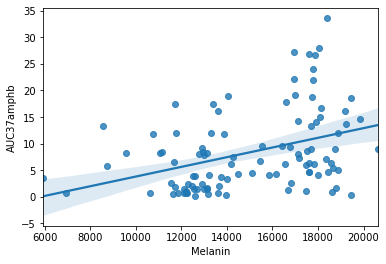

In [77]:
sns.regplot(x='Melanin',y='AUC37amphb',data=pheno)

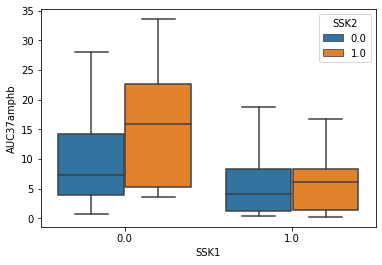

In [78]:
sns.boxplot(x='SSK1',y='AUC37amphb',hue='SSK2',data=pheno);

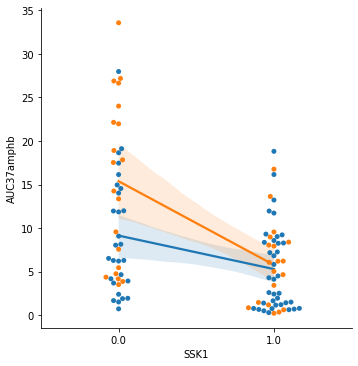

In [79]:
sns.lmplot(x='SSK1',y='AUC37amphb',hue='SSK2',data=pheno,scatter_kws={'alpha':0},legend_out=False);
g = sns.swarmplot(x='SSK1',y='AUC37amphb',hue='SSK2',data=pheno);
g.legend_.remove()

In [80]:
pheno['AUC39amphb'] = pheno['39_0.125']

In [81]:
import statsmodels.api as sm

In [82]:
model= smf.ols('AUC37amphb~SSK1*SSK2',data=pheno).fit()

In [83]:
anova_table = sm.stats.anova_lm(model,typ=2)

In [84]:
anova_table

,sum_sq,df,F,PR(>F)
SSK1,935.145596,1.0,22.146683,0.000008
SSK2,256.393635,1.0,6.072069,0.015440
SSK1:SSK2,201.218414,1.0,4.765376,0.031378
Residual,4222.508593,100.0,NaN,NaN


In [85]:
pheno.columns

Index(['Melanin', 'Fludioxonil', 'H2O2', '30_0.0', '30_0.075', '30_0.125',
       '30_0.175', '37_0.0', '37_0.075', '37_0.125', '37_0.175', '39_0.0',
       '39_0.075', '39_0.125', 'QTL14', 'NaCl_1M', 'Cell_and_Capsule', 'Cell',
       'Capsule', 'Cell_and_Capsule_diameter', 'Cell_diameter',
       'Capsule_diameter', 'Capsule_diameter_residual',
       'Cell_diameter_residual', 'RIC8', 'SSK1', 'SSK2', 'new_mosaic', 'SSK1r',
       'SSK2r', 'RIC8r', 'AUC37', 'AUC_37', 'AUC39', 'AUC37amphb',
       'AUC39amphb'],
      dtype='object')

In [86]:
smf.ols('H2O2~RIC8*SSK2',data=pheno).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   H2O2   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     11.96
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           9.34e-07
Time:                        14:44:08   Log-Likelihood:                -193.87
No. Observations:                 104   AIC:                             395.7
Df Residuals:                     100   BIC:                             406.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2065      0.332      9.661      0.000       2.548       3.865
RIC8          -1.7601      0.413     -4.263      0.000      -2.579      -0.941
SSK2           0.1685      0.456      0.370      0.712      -0.735       1.072
RIC8:SSK2      1.9043      0.680      2.799      0.006       0.555       3.254
==============================================================================
Omnibus:                        6.709   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                4.023
Skew:                          -0.298   Prob(JB):                        0.134
Kurtosis:                       2.243   Cond. No.                         6.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

smf.ols('H2O2~RIC8SSK2',data=pheno).fit().summary()

smf.ols('AUC39AB0125 ~ SSK1 + SSK2*RIC8 - SSK2',data=pheno).fit().summary()

smf.ols('AUC39 ~ RIC8*SSK1*SSK2 - RIC8:SSK1',data=pheno).fit().summary()

smf.ols('Melanin ~ RIC8',data=pheno).fit().summary()

smf.ols('Capsule_diameter_residual~RIC8',data=pheno).fit().summary()

smf.ols('H2O2~RIC8*SSK2*SSK1-SSK2-SSK1:SSK2',data=pheno).fit().summary()

In [87]:
ss.normaltest(pheno.H2O2.values)

NormaltestResult(statistic=120.75820535198307, pvalue=5.993615592850579e-27)

In [88]:
#pheno.to_csv('/home/croth/Desktop/Cdx_phenos.csv.gz')

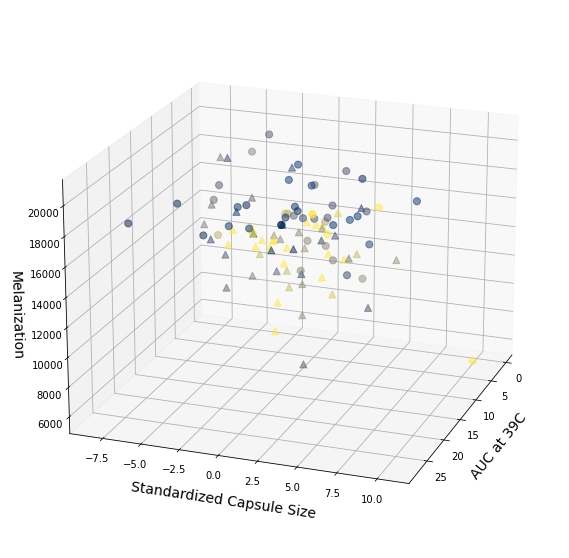

In [89]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ms = ['o','^']
for i in [0,1]:
    phe = pheno[(pheno.RIC8==i)]
    ax.scatter3D(phe['39_0.0'], phe['Capsule_diameter_residual'], 
             phe['Melanin'], c=phe['H2O2'], 
             cmap='cividis_r',s=50,alpha=0.5,marker=ms[i]);
ax.view_init(20,20);

ax.set_xlabel('\nAUC at 39C',fontsize=14)
ax.set_ylabel('\nStandardized Capsule Size',fontsize=14)
ax.set_zlabel('\nMelanization',fontsize=14);
#plt.savefig('Chromosome_14_phetypes.png',dpi=100,bbox_inches='tight');

In [90]:
pheno[['H2O2','Fludioxonil','30_0.125','37_0.125',
       '37_0.175','39_0.0','39_0.125','Melanin',
       'Capsule_diameter_residual']].corr(method='spearman')

,H2O2,Fludioxonil,30_0.125,37_0.125,37_0.175,39_0.0,39_0.125,Melanin,Capsule_diameter_residual
H2O2,1.000000,-0.354599,0.492671,0.503808,0.393437,0.527965,0.588610,0.589647,0.150154
Fludioxonil,-0.354599,1.000000,-0.412900,-0.379117,-0.365041,-0.163283,-0.420518,-0.153899,-0.075073
30_0.125,0.492671,-0.412900,1.000000,0.586632,0.550912,0.457132,0.638864,0.244692,0.060461
37_0.125,0.503808,-0.379117,0.586632,1.000000,0.715897,0.659917,0.531180,0.397503,0.268388
37_0.175,0.393437,-0.365041,0.550912,0.715897,1.000000,0.503457,0.501946,0.404406,0.239326
39_0.0,0.527965,-0.163283,0.457132,0.659917,0.503457,1.000000,0.578602,0.512184,0.427152
39_0.125,0.588610,-0.420518,0.638864,0.531180,0.501946,0.578602,1.000000,0.399032,0.347956
Melanin,0.589647,-0.153899,0.244692,0.397503,0.404406,0.512184,0.399032,1.000000,0.185778
Capsule_diameter_residual,0.150154,-0.075073,0.060461,0.268388,0.239326,0.427152,0.347956,0.185778,1.000000


In [91]:
ss.spearmanr(pheno.H2O2.values,pheno['37_0.125'].values)

SpearmanrResult(correlation=0.5038081943444647, pvalue=4.985743572260893e-08)

In [92]:
ss.spearmanr(pheno.H2O2.values,pheno['39_0.0'].values)

SpearmanrResult(correlation=0.5279649280723954, pvalue=8.437737052986333e-09)

In [93]:
for p in ['Fludioxonil','37_0.125','37_0.175','39_0.125','39_0.0','Melanin','Capsule_diameter_residual']:
    
    print(p,ss.spearmanr(pheno.H2O2.values,pheno[p].values))

Fludioxonil SpearmanrResult(correlation=-0.3545986788195882, pvalue=0.0002213872207820664)
37_0.125 SpearmanrResult(correlation=0.5038081943444647, pvalue=4.985743572260893e-08)
37_0.175 SpearmanrResult(correlation=0.3934365402199433, pvalue=3.60092245185135e-05)
39_0.125 SpearmanrResult(correlation=0.5886095509617967, pvalue=4.9892298178851554e-11)
39_0.0 SpearmanrResult(correlation=0.5279649280723954, pvalue=8.437737052986333e-09)
Melanin SpearmanrResult(correlation=0.5896468416300287, pvalue=4.527389183988682e-11)
Capsule_diameter_residual SpearmanrResult(correlation=0.15015447262038575, pvalue=0.12815614793539765)


In [94]:
h202_pval = geno_df[segs].drop_duplicates().apply(allelic_ANOVA, 
                                        args = [pheno['39_0.125'].T[segs].values],
                                                 axis=1)

In [95]:
ss.spearmanr(pheno.H2O2.values,pheno['39_0.125'].values)

SpearmanrResult(correlation=0.5886095509617967, pvalue=4.9892298178851554e-11)

In [96]:
ss.spearmanr(pheno.H2O2.values,pheno['Fludioxonil'].values)

SpearmanrResult(correlation=-0.3545986788195882, pvalue=0.0002213872207820664)

In [97]:
ssk1 = pd.read_csv('/home/croth/Desktop/Parametric/CNB03090.csv',index_col=0)
ssk2 = pd.read_csv('/home/croth/Desktop/Parametric/CNL05560.csv',index_col=0)
ric8 = pd.read_csv('/home/croth/Desktop/Parametric/CNN01270.csv',index_col=0)

In [98]:
ssk1gv = geno_df[(geno_df.Chrom=='Chr02') & 
                 (geno_df.Pos>=ssk1.Start.min()) & 
                 (geno_df.Pos<=ssk1.End.max())][segs].mode().dropna()

ssk2gv = geno_df[(geno_df.Chrom=='Chr12') & 
                 (geno_df.Pos>=ssk2.Start.min()) & 
                 (geno_df.Pos<=ssk2.End.max())][segs].mode().dropna()

ric8gv = geno_df[(geno_df.Chrom=='Chr14') & 
                 (geno_df.Pos>=ric8.Start.min()) & 
                 (geno_df.Pos<=ric8.End.max())][segs].mode().dropna()

qtl_gv = pd.concat([ssk1gv,ssk2gv,ric8gv]).T
qtl_gv.columns = ['SSK1','SSK2','RIC8']

In [99]:
for g in qtl_gv.columns:
    pheno[g] = qtl_gv.T[pheno.index].T[g]

In [100]:
pheno

,Melanin,Fludioxonil,H2O2,30_0.0,30_0.075,30_0.125,30_0.175,37_0.0,37_0.075,37_0.125,...,SSK2,new_mosaic,SSK1r,SSK2r,RIC8r,AUC37,AUC_37,AUC39,AUC37amphb,AUC39amphb
SS-A837,11169.802000,1.0,2.00,72.846625,6.396750,1.581000,2.054625,60.49275,39.584125,8.383125,...,1.0,1,431$\mathrm{\alpha}$,431$\mathrm{\alpha}$,431$\mathrm{\alpha}$,8.383125,2.895363,17.089875,8.383125,0.012600
SS-B307,12310.311000,1.0,0.75,41.768125,23.671750,13.471400,8.164875,25.04775,14.971500,2.394925,...,0.0,7,XL280$\bf{a}$,XL280$\bf{a}$,431$\mathrm{\alpha}$,2.394925,1.547555,15.147750,2.394925,0.000000
SS-B310,12255.142667,1.0,0.00,42.613800,5.368000,0.677750,0.385800,11.57150,0.609500,0.653250,...,0.0,5,431$\mathrm{\alpha}$,XL280$\bf{a}$,431$\mathrm{\alpha}$,0.653250,0.808239,0.001550,0.653250,0.035575
SS-B311,14045.272333,0.0,4.00,51.629500,47.838975,37.815875,26.589250,25.22050,21.242500,18.908500,...,1.0,3,XL280$\bf{a}$,431$\mathrm{\alpha}$,431$\mathrm{\alpha}$,18.908500,4.348391,8.145000,18.908500,4.815250
SS-B312,18635.336333,0.0,5.00,34.049937,22.844500,5.067400,1.533375,16.75800,13.019000,5.445800,...,1.0,2,XL280$\bf{a}$,431$\mathrm{\alpha}$,XL280$\bf{a}$,5.445800,2.333624,8.318375,5.445800,0.355025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SS-C272,8753.444667,1.0,3.75,43.949125,24.359000,15.252375,9.834250,25.19600,8.879825,5.822625,...,0.0,5,431$\mathrm{\alpha}$,XL280$\bf{a}$,431$\mathrm{\alpha}$,5.822625,2.413012,4.517250,5.822625,0.028675
SS-C290,12548.160000,1.0,4.00,68.294250,10.636000,8.575750,3.587625,33.49700,9.221500,1.456500,...,1.0,1,431$\mathrm{\alpha}$,431$\mathrm{\alpha}$,431$\mathrm{\alpha}$,1.456500,1.206855,11.899625,1.456500,0.399200
SS-C291,18622.775333,1.0,3.75,71.006875,14.759000,6.783250,1.210525,29.16125,9.942000,0.847625,...,1.0,6,431$\mathrm{\alpha}$,431$\mathrm{\alpha}$,XL280$\bf{a}$,0.847625,0.920666,16.477375,0.847625,0.079050
XL280a,18894.701000,1.0,4.50,40.878300,33.301625,24.437825,13.611125,28.70725,20.095050,11.984250,...,0.0,0,XL280$\bf{a}$,XL280$\bf{a}$,XL280$\bf{a}$,11.984250,3.461828,20.767625,11.984250,10.402975


In [101]:
pheno[['Melanin','39_0.0','H2O2','Cell_and_Capsule_diameter','Capsule_diameter','Capsule_diameter_residual']].corr(method='spearman')

,Melanin,39_0.0,H2O2,Cell_and_Capsule_diameter,Capsule_diameter,Capsule_diameter_residual
Melanin,1.000000,0.512184,0.589647,-0.435683,-0.339849,0.185778
39_0.0,0.512184,1.000000,0.527965,-0.415103,-0.206092,0.427152
H2O2,0.589647,0.527965,1.000000,-0.191182,-0.147741,0.150154
Cell_and_Capsule_diameter,-0.435683,-0.415103,-0.191182,1.000000,0.816235,-0.207650
Capsule_diameter,-0.339849,-0.206092,-0.147741,0.816235,1.000000,0.265102
Capsule_diameter_residual,0.185778,0.427152,0.150154,-0.207650,0.265102,1.000000


In [102]:
ss.spearmanr(pheno.Melanin.values,pheno.Capsule_diameter_residual)

SpearmanrResult(correlation=0.1857782993705324, pvalue=0.0590060658044548)

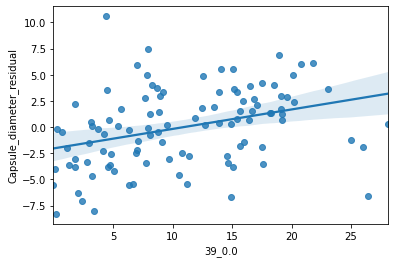

In [103]:
sns.regplot(x='39_0.0',y='Capsule_diameter_residual',data=pheno);

In [104]:
ss.pearsonr(pheno.Capsule_diameter_residual,pheno['39_0.0'])

(0.3452217319253465, 0.0003319076206579464)

In [105]:
ss.spearmanr(pheno.Capsule_diameter_residual,pheno['Melanin'])

SpearmanrResult(correlation=0.1857782993705324, pvalue=0.0590060658044548)

In [106]:
ss.spearmanr(pheno.Capsule_diameter_residual,pheno['39_0.0'])

SpearmanrResult(correlation=0.4271524591912942, pvalue=6.122331718174313e-06)

In [107]:
ss.spearmanr(pheno.Melanin,pheno['39_0.0'])

SpearmanrResult(correlation=0.5121839325722821, pvalue=2.735238128581478e-08)

In [108]:
for p in ['Melanin','39_0.0','Capsule_diameter_residual']:
    print(ss.spearmanr(pheno['H2O2'],pheno[p]))

SpearmanrResult(correlation=0.5896468416300287, pvalue=4.527389183988682e-11)
SpearmanrResult(correlation=0.5279649280723954, pvalue=8.437737052986333e-09)
SpearmanrResult(correlation=0.15015447262038575, pvalue=0.12815614793539765)


In [109]:
pheno[['Melanin','39_0.0','Capsule_diameter',
       'Capsule_diameter_residual','H2O2']].corr(method='spearman')

,Melanin,39_0.0,Capsule_diameter,Capsule_diameter_residual,H2O2
Melanin,1.000000,0.512184,-0.339849,0.185778,0.589647
39_0.0,0.512184,1.000000,-0.206092,0.427152,0.527965
Capsule_diameter,-0.339849,-0.206092,1.000000,0.265102,-0.147741
Capsule_diameter_residual,0.185778,0.427152,0.265102,1.000000,0.150154
H2O2,0.589647,0.527965,-0.147741,0.150154,1.000000


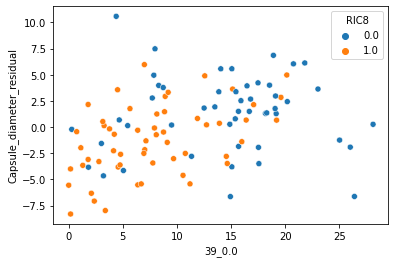

In [110]:
sns.scatterplot(x='39_0.0',y='Capsule_diameter_residual',hue='RIC8',data=pheno);

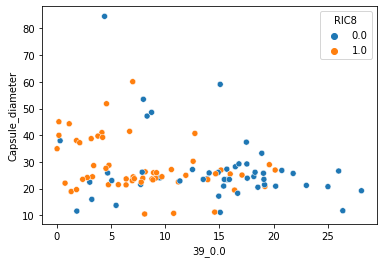

In [111]:
sns.scatterplot(x='39_0.0',y='Capsule_diameter',hue='RIC8',data=pheno);

In [112]:
ss.spearmanr(pheno.Capsule_diameter_residual,pheno['39_0.0'])

SpearmanrResult(correlation=0.4271524591912942, pvalue=6.122331718174313e-06)

In [113]:
ss.spearmanr(pheno.Capsule_diameter,pheno['Melanin'])

SpearmanrResult(correlation=-0.3398485010135496, pvalue=0.0004162475986292724)

In [114]:
ss.spearmanr(pheno.Capsule_diameter,pheno['Melanin'])

SpearmanrResult(correlation=-0.3398485010135496, pvalue=0.0004162475986292724)

In [115]:
#pheno_z['QTL14'] = pheno.QTL14

In [116]:
ric8 = np.array([386833, 389698])

In [117]:
ch14data = pheno[['Melanin','Capsule_diameter_residual','39_0.0','QTL14']].copy()
for p in ch14data.columns.tolist()[:-1]:
    
    ch14data[p] = np.array(myminmax(ch14data[p].values),dtype=float)

In [118]:
hl,hr = 279819.0, 425700.0
cl,cr = 354579.0, 668746.0
ml,mr = 368955.0, 403449.0

In [119]:
chr14p = pd.read_csv('~/Cdx_chrom_14_QTLs.csv',index_col=0)

In [120]:
chr14p.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,Residual_Pval,Melanin_Pval,H2O2_Pval,HTG_Pval
88605,Chr14,6648,146846.0,1.0,T,G,1,8809,snp,230,...,1.0,1.0,0.0,0.0,1.0,1.0,0.03185,0.513838,0.062909,0.044573
88606,Chr14,15301,89905.0,1.0,CTTTTTTTTTTTAAAAAAAAGGT,CTTTTTTTTTTAAAAAAAAAGGT,1,6238,indel,348,...,1.0,1.0,0.0,0.0,1.0,1.0,0.03185,0.513838,0.062909,0.044573
88607,Chr14,24175,156761.0,1.0,C,T,1,9515,snp,531,...,1.0,1.0,0.0,0.0,1.0,1.0,0.03185,0.513838,0.062909,0.044573
88608,Chr14,28073,139655.0,1.0,CA,CG,1,8586,indel,619,...,1.0,1.0,0.0,0.0,1.0,1.0,0.02624,0.645730,0.000875,0.220770
88609,Chr14,28198,139875.0,1.0,TTACA,TTACG,1,8498,indel,624,...,1.0,1.0,0.0,0.0,1.0,1.0,0.02624,0.645730,0.000875,0.220770


In [121]:
from matplotlib import rc
xl280al = 'XL280'+r'$\alpha$'#+'SS'
xl280_label = 'XL280' +r'$\bf{a}$'
_431_label = '431'+r'$\mathrm{\alpha}$'

In [122]:
melanin.head()

,Mean_intensity,QTL14
Strain,,
SS-B307,12310.311000,1
SS-B310,12255.142667,1
SS-B311,14045.272333,1
SS-B312,18635.336333,0
SS-B313,16597.829333,0


In [123]:
ch14data['Mel_QTL'] = melanin['QTL14'].T[ch14data.index].T

In [124]:
ch14data['Melanization QTL Allele'] = [_431_label if a == 1 else xl280_label 
                                         for a in ch14data.Mel_QTL]

In [125]:
import statsmodels.formula.api as smf

In [126]:
ch14data.head()

,Melanin,Capsule_diameter_residual,39_0.0,QTL14,Mel_QTL,Melanization QTL Allele
SS-A837,0.356855,0.553224,0.607624,1.0,1,431$\mathrm{\alpha}$
SS-B307,0.434467,0.632144,0.538566,1.0,1,431$\mathrm{\alpha}$
SS-B310,0.430713,0.145736,0.000000,1.0,1,431$\mathrm{\alpha}$
SS-B311,0.552532,0.505906,0.289563,1.0,1,431$\mathrm{\alpha}$
SS-B312,0.864887,0.650523,0.295728,0.0,0,XL280$\bf{a}$


In [127]:
ch14data.columns = ['Melanin','Capsule_diameter','HTG','QTL14','MELQTL','Melanization QTL Allele']

In [128]:
ch14data.head()

,Melanin,Capsule_diameter,HTG,QTL14,MELQTL,Melanization QTL Allele
SS-A837,0.356855,0.553224,0.607624,1.0,1,431$\mathrm{\alpha}$
SS-B307,0.434467,0.632144,0.538566,1.0,1,431$\mathrm{\alpha}$
SS-B310,0.430713,0.145736,0.000000,1.0,1,431$\mathrm{\alpha}$
SS-B311,0.552532,0.505906,0.289563,1.0,1,431$\mathrm{\alpha}$
SS-B312,0.864887,0.650523,0.295728,0.0,0,XL280$\bf{a}$


In [129]:
ch14data[['Melanin','HTG']].corr().values[0][-1]**2

0.266020555578252

In [130]:
HTG_Mel_fit = smf.ols('HTG ~ Melanin',data=ch14data).fit()
htg_mel_rs = np.round(HTG_Mel_fit.rsquared,2)

CELL_Mel_fit = smf.ols('Capsule_diameter ~ Melanin',data=ch14data).fit()
cell_mel_rs = np.round(CELL_Mel_fit.rsquared,2)

In [131]:
spearman_r = pheno[['Melanin','Capsule_diameter_residual','39_0.0','H2O2']].corr(method='spearman')

In [132]:
spearman_r

,Melanin,Capsule_diameter_residual,39_0.0,H2O2
Melanin,1.000000,0.185778,0.512184,0.589647
Capsule_diameter_residual,0.185778,1.000000,0.427152,0.150154
39_0.0,0.512184,0.427152,1.000000,0.527965
H2O2,0.589647,0.150154,0.527965,1.000000


In [133]:
auc39_cap_cor = np.round(spearman_r[['39_0.0']].T['Capsule_diameter_residual'].min(),2)
auc39_mel_cor = np.round(spearman_r[['39_0.0']].T['Melanin'].min(),2)

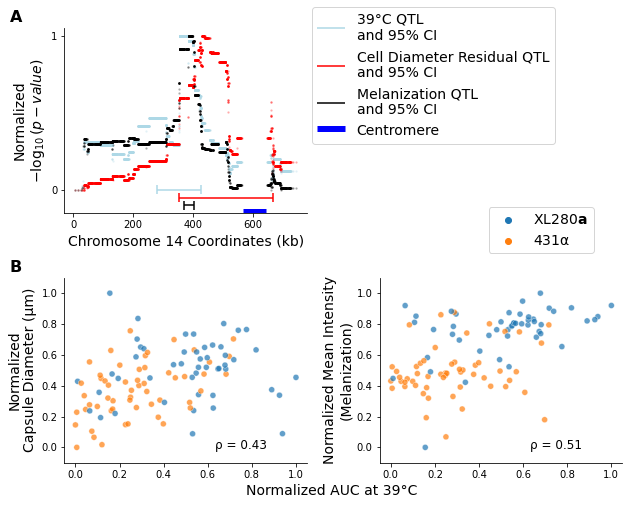

In [134]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
plt.sca(ax[0,1]);plt.axis('off')

plt.sca(ax[0,0])
[ax[0,0].spines[a].set_visible(False) for a in ['top','right']]

kb = 1000
ls = 0.03
yp = -0.05


plt.plot(chr14p.Pos.values/kb,
        myminmax(chr14p.HTG_Pval.values),'.',
         color='lightblue',alpha=0.2,ms=3)#,label=u'39°C QTL')
plt.hlines(yp+0.05,hl/kb,hr/kb,color='lightblue',label=u'39°C QTL\nand 95% CI');
plt.vlines((hl/kb,hr/kb),yp+0.05-ls,yp+0.05+ls,color='lightblue');

plt.plot(chr14p.Pos.values/kb,
         myminmax(chr14p.Residual_Pval.values),
         'r.',alpha=0.2,ms=3)#,label='Capsule\nResidual QTL');
plt.hlines(yp,cl/kb,cr/kb,color='r',label='Cell Diameter Residual QTL\nand 95% CI');
plt.vlines((cl/kb,cr/kb),yp-ls,yp+ls,color='r');

plt.plot(chr14p.Pos.values/kb,
         myminmax(chr14p.Melanin_Pval.values),
         'k.',alpha=0.2,ms=3)#,label='Melanization QTL')
plt.hlines(yp-0.05,ml/kb,mr/kb,color='k',label='Melanization QTL\nand 95% CI');
plt.vlines((ml/kb,mr/kb),yp-0.05-ls,yp-0.05+ls,color='k');
plt.hlines(-0.17,568029/kb,644419/kb,linewidth=15,
           color='blue',label='Centromere');

#plt.plot(chr14p.Pos.values/kb,
#        myminmax(chr14p.H2O2_Pval.values),'.',
#         color='olive',alpha=0.2)#,label=u'39°C QTL')
#plt.hlines(yp-0.3,h2l/kb,h2r/kb,color='olive',label=u'H$_{2}$O$_{2}$ QTL\nand 95% CI');
#plt.vlines((h2l/kb,h2r/kb),yp-0.3-ls,yp-0.3+ls,color='olive');

plt.ylim(-0.15,1.05)
plt.yticks([0,1])
plt.legend(bbox_to_anchor = (2.05,1.15),fontsize=14,frameon=True)

plt.xlabel('Chromosome 14 Coordinates (kb)',fontsize=14);
plt.ylabel('Normalized\n$-\log_{10}\,(p-value)$',fontsize=14);

plt.title('A',fontsize=16,fontweight='bold',x=-.2,y=1)

## ----------------------------------------------------------------------------- ##

plt.sca(ax[1,0])
[ax[1,0].spines[a].set_visible(False) for a in ['top','right']]

#sns.regplot(x='Melanin',y='Capsule_diameter',
#            data=ch14data,scatter_kws={'alpha':0.0},
#            line_kws={'color':'grey','alpha':0.5});
sns.scatterplot(x='HTG',y='Capsule_diameter',data=ch14data,alpha=0.7,
                hue='Melanization QTL Allele',
                hue_order=[xl280_label,_431_label])

plt.legend(bbox_to_anchor=(2.21,1.42),fontsize=14,frameon=True)
plt.xlabel(' ')
plt.ylabel('Normalized\nCapsule Diameter (\u03BCm)',fontsize=14)

plt.ylim(-0.1,1.1)

plt.title('B',fontsize=16,fontweight='bold',x=-.2,y=1)

#plt.text(s='$R^2 = %s$'%cell_mel_rs,fontsize=12,x=0.15,y=1,va='center',ha='center')
plt.text(s='\u03C1 = %s'%auc39_cap_cor,fontsize=12,x=0.75,y=.01,va='center',ha='center')
## ------------------------------------------------------------------------------- ##

plt.sca(ax[1,1])

[ax[1,1].spines[a].set_visible(False) for a in ['top','right']]

#sns.regplot(x='Melanin',y='HTG',data=ch14data,
#            scatter_kws={'alpha':0.0},
#            line_kws={'color':'grey','alpha':0.5});
sns.scatterplot(y='Melanin',x='HTG',data=ch14data,hue='Melanization QTL Allele',
                hue_order=[xl280_label,_431_label],legend=None,alpha=0.7)

plt.ylabel('Normalized Mean Intensity\n(Melanization)',fontsize=14,x=-.2)
plt.xlabel('Normalized AUC at 39°C',fontsize=14,x=-.2)

plt.ylim(-0.1,1.1)
#plt.text(s='$R^2 = %s$'%htg_mel_rs,fontsize=12,x=0.15,y=1,va='center',ha='center')
plt.text(s='\u03C1 = %s'%auc39_mel_cor,fontsize=12,x=0.75,y=.01,va='center',ha='center')

plt.subplots_adjust(wspace=0.3,hspace=0.35)


plt.sca(ax[0,0])
sub1 = fig.add_axes([0.47,.71,0.05,0.01])
plt.xticks([]);plt.yticks([]);
[sub1.spines[a].set_visible(False) for a in ['top','right','left','bottom']]

sub1 = fig.add_axes([0.47,.685,0.05,0.015])
plt.xticks([]);plt.yticks([]);
[sub1.spines[a].set_visible(False) for a in ['top','right','left','bottom']]

#plt.savefig('./Cdx_Chromosome14_QTL_Cell_HTG_Melanization.png',
plt.savefig('../FIGURES/SUPP/PDFs/S7_Fig.pdf',
             dpi=300,bbox_inches='tight');

In [135]:
pheno.to_csv('/home/croth/Desktop/Cdx_phenotypes.csv.gz',index=True)